<a href="https://colab.research.google.com/github/tzlilLV97/Task3_DeepLearning/blob/main/Final_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alon Feldman 312213135**

**Tzlil Lev-or 318646510**

# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import random

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

# load different path and images
import glob
path_train = "/content/gdrive/My Drive/Colab Notebooks/data/train/*.jpg" 
path_test_m = "/content/gdrive/My Drive/Colab Notebooks/data/test_m/*.jpg" 
path_test_w = "/content/gdrive/My Drive/Colab Notebooks/data/test_w/*.jpg" 

images = [{},{},{}]

path=[path_train,path_test_m,path_test_w]
for i,pat in enumerate(path):
  for file in glob.glob(pat):
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      images[i][filename] = (img[:, :, :3]/255-0.5) # remove the alpha channel


In [ ]:
# this code to extracte the ID of each picture and store the differente ID
# in "people" (each ID represante 1 person)
people=[[],[],[]]
for j in range(len(images)):
  for i in range(0,9):
    people[j].append(list(filter(lambda x : "u00{}".format(i) in x,images[j].keys())))
  for i in range(10,100):
    people[j].append(list(filter(lambda x : "u0{}".format(i) in x,images[j].keys())))
  for i in range(100,134):
    people[j].append(list(filter(lambda x : "u{}".format(i) in x,images[j].keys())))
  people[j] = list(people[j])
  people[j] = [x for x in people[j] if len(x)>0]
  people[j]=[sorted(sorted(x,key=lambda x:x.split('_')[2]),key=(lambda x: x.split('_')[1])) for x in people[j]]

#make ndarray for each data set
train_data=np.ndarray(shape=(len(people[0]),3,2,224,224,3))
test_m=np.ndarray(shape=(len(people[1]),3,2,224,224,3))
test_w=np.ndarray(shape=(len(people[2]),3,2,224,224,3))
# copy the data to the ndarray- for person i , the j pair, the s side
for i,pep in enumerate(people[0]):
  for j in range(3):
    for s in range(2):
      train_data[i][j][s]=images[0][pep[2*j+s]]
for i,pep in enumerate(people[1]):
  for j in range(3):
    for s in range(2):
      test_m[i][j][s]=images[1][pep[2*j+s]]
for i,pep in enumerate(people[2]):
  for j in range(3):
    for s in range(2):
      test_w[i][j][s]=images[2][pep[2*j+s]]

#split data to train and validation
split_index = int(len(train_data)*0.8)
train_data, valid_data = np.split(train_data,[split_index])
#checking for rigth dimentions
print(train_data.shape)
print(valid_data.shape)
print(test_m.shape)
print(test_w.shape)

(88, 3, 2, 224, 224, 3)
(23, 3, 2, 224, 224, 3)
(10, 3, 2, 224, 224, 3)
(10, 3, 2, 224, 224, 3)


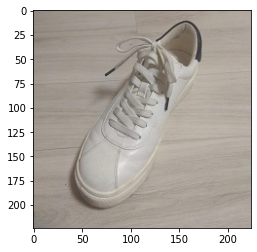

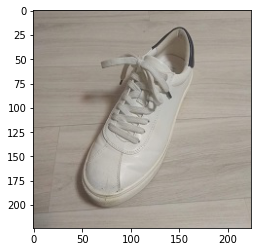

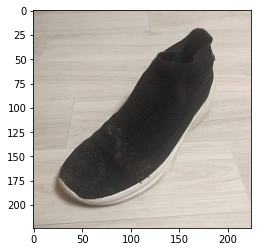

In [ ]:
# Run this code, include the image in your PDF submission
# We add +0.5 to deal with the "negative pixels" and to see the picture more brightly
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(88, 3, 2, 224, 224, 3)
(264, 448, 224, 3)


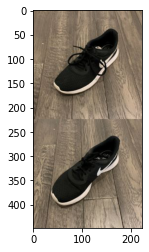

In [ ]:
# Your code goes here
def generate_same_pair(data):
  sh=data.shape
  res=np.ndarray(shape=(sh[0]*sh[1],448,224,3)) #make output ndarry
  i=0
  for pep in data:
    for j in range(3):  #concatenate the picture of the same pair (so both of them for the j pair of the=at person)
      res[i]=np.concatenate((pep[j][0],pep[j][1]),axis=0)
      i+=1
  return res
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(88, 3, 2, 224, 224, 3)
(264, 448, 224, 3)


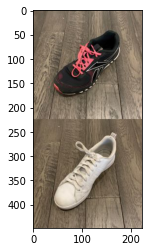

In [ ]:
# Your code goes here
def generate_different_pair(data):
  sh=data.shape
  res=np.ndarray(shape=(sh[0]*sh[1],448,224,3))
  i=0
  pairs = list(itertools.product([0, 1, 2], repeat=2))  #create list of all differente combinations and then
  pairs=[pair for pair in pairs if pair[0]!=pair[1]]    # drop the combinations of the same pair (like 1,1)
  for pep in data:
    temp=random.sample(pairs, 3)   #choose 3 random combinations from all the possibles
    for j in range(3):
      res[i]=np.concatenate((pep[temp[j][0]][0],pep[temp[j][1]][1]),axis=0)
      i+=1
  return res


# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**
We want the model's inference rule to be based on whether two shoes belong to the same pair. However, the model may find other inference rules such as whether the shoes are the same size, gender, or have the same background. By exposing the model to different shoes that do not belong to the same person, it may derive its answers based on factors such as the person's gender, shoe size, or other characteristics. This could lead to incorrect predictions or bias in the model's performance. To avoid this, it is important to ensure that the different pairs of shoes come from the same person so that the model's inference rule is based only on whether the shoes belong to the same pair.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**
The Model assume always that the sample are I.I.D. from the true data distribution, but if we'll insert samples that are 99% from class A and 1% from class B, it won't reflect the true distribution (50-50).
As a resulte, he will learnd a fake-distrubaion and will predicte almost always "class A" on the test set- but the test is indeed from the true distrubation so is 50-50.
If 99% of our shoes are not from the same pair and only 1% are, our model tends to prioritize learning from the majority and will therefore often guess that two pictures of shoes do not depict a matching pair.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [ ]:
class CNN(nn.Module):
    def __init__(self, myN=4,myKernel=3):
        super(CNN, self).__init__()
        self.n=myN
        self.kernel_size=myKernel
        # input size 3*H(448)*W(224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- n*H(224)*W(112)
        self.conv2 = nn.Conv2d(in_channels=self.n, out_channels=2*self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- 2n*H(112)*W(56)
        self.conv3 = nn.Conv2d(in_channels=2*self.n, out_channels=4*self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- 4n*H(56)*W(28)
        self.conv4 = nn.Conv2d(in_channels=4*self.n, out_channels=8*self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- 8n*H(28)*W(14)
        self.pool = nn.MaxPool2d(kernel_size=2)
        #so the input to the fully-connected layer is 8n*28*14
        self.fc1 = nn.Linear(in_features=8*self.n*28*14, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=2)

        self.relu= nn.ReLU()


    def forward(self, x):    #each step is conv->relu->maxPool
        x = self.conv1(x)
        x=  self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x=  self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x=  self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x=  self.relu(x)
        x = self.pool(x)

        # Flatten the output of the convolutional layers
        x = x.reshape(-1,self.n*8*14*28)
        x = self.fc1(x)
        x=  self.relu(x)
        x = self.fc2(x)
        return x



### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, myN=4,myKernel=3):
        super(CNNChannel, self).__init__()
        self.n=myN
        self.kernel_size=myKernel
        # input size 6*H(224)*W(224)
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- n*H(112)*W(112)
        self.conv2 = nn.Conv2d(in_channels=self.n, out_channels=2*self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- 2n*H(56)*W(56)
        self.conv3 = nn.Conv2d(in_channels=2*self.n, out_channels=4*self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- 4n*H(28)*W(28)
        self.conv4 = nn.Conv2d(in_channels=4*self.n, out_channels=8*self.n, kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        # after conv with paddind and max pool- 8n*H(14)*W(14)
        self.pool = nn.MaxPool2d(kernel_size=2)
        #so the input to the fully-connected layer is 8n*14*14
        self.fc1 = nn.Linear(in_features=8*self.n*14*14, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=2)

        self.relu= nn.ReLU()

    def forward(self, x): #each step is conv->relu->maxPool
        x= torch.cat(torch.split(x,224,dim=2),1)  #make the dim like we want
        x = self.conv1(x)
        x=  self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x=  self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x=  self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x=  self.relu(x)
        x = self.pool(x)

        # Flatten the output of the convolutional layers
        x = x.reshape(-1,self.n*8*14*14)

        x = self.fc1(x)
        x= self.relu(x)
        x = self.fc2(x)
        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**
Convolutional neural networks (CNNs) are effective at processing images because they take advantage of the inherent stationarity and locality of images. This allows the network to use weight sharing and sparsity to process the data efficiently. When concatenating images along the vertical dimension, the locality of the image is disrupted along the concatenation line and the stationarity of the images is also compromised due to the different angles, patterns, lighting, etc. present in the different images. In contrast, concatenating images along the channel dimension preserves the locality and stationarity of the images, which is why the **CNNChannel model is likely to perform better than the CNN model.** The CNNChannel model can treat each channel separately, maintaining the locality and stationarity of the images, while the CNN model does not have this advantage.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**
When doing classification task, we can measure accuaracy by other measures (like Precision, Sensitivity, Recall , etc.) which can led for better understanding of the model preformence and strength or weakness.
When we compute the model accuracy on the positive and negative samples, we obtain extra information (True Positive, False Negative, True Negative, False Positive) that we can take into our advantage, for example, when prediction medical disease, we would want our false negative to be minimized, so if we get a high accuracy, but our false negative rate is high, we didn't achieve anything. 

For example let's say our model's accuracy of 10 shoes is 80%, sound nice but when we look deeper we see : TP=1, FN=2, TN=7, FP=0 -> we can conculde that our model preforms like "stupid model" that just gusse "not the same pair".

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]
    #in out network we decide to do oneHot of '[1,0]' for positive and '[0,1]' for negative
    # so the index for positive is 0 and for negative is 1
    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]
    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3).transpose(2,3) #from [3n,448,224,3] to [3n,3,448,224]
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1]# get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 0).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3).transpose(2,3) #from [3n,448,224,3] to [3n,3,448,224]
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 1).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)
model = CNN() # create untrained model
pos_acc, neg_acc= get_accuracy(model, valid_data)
false_positive = 1 - pos_acc
false_negative = 1 - neg_acc
print(pos_acc, neg_acc, false_positive, false_negative)

0.0 1.0 1.0 0.0


## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
# Write your code here
def shuffle(data):   #to shuffel data every epoch
  shuffled_indices = np.random.permutation(len(data))
  return data[shuffled_indices]

def train_model(model,training_data,validation_data,
                                 batch_size=50,
                                 epoch=2,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration or "epoch" - what ever come before.
    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve. also it can save the weigth.
    """
    #init parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    parameter=[learning_rate,weight_decay,batch_size,epoch]
    #get the data ready
    false_train_sample=generate_different_pair(training_data)
    true_train_sample=generate_same_pair(training_data)

    n = 0 # the number of iterations
    while True:
      for epoch in range(epoch):
        #each epoch shuffel the train_data
        false_train_sample= shuffle(false_train_sample)
        true_train_sample=shuffle(true_train_sample)
        for i in range(0, true_train_sample.shape[0], batch_size//2):
          if (i + batch_size//2) > true_train_sample.shape[0]:
            break

          # get the input and targets of a minibatch
          false_batch=false_train_sample[i:i+(batch_size//2)]
          true_batch=true_train_sample[i:i+(batch_size//2)]
          #make one_hot vector for label -> "[1,0]" for same_pair, "[0,1]" for different_pair
          true_label=np.ones((batch_size//2,2)) 
          false_label=np.ones((batch_size//2,2))
          true_label[:,1]=0
          false_label[:,0]=0
          xt=np.concatenate((false_batch,true_batch),axis=0)
          st=np.concatenate((false_label,true_label),axis=0)
          #shuffle batch
          shuff_index=np.random.permutation(len(xt))
          xt=xt[shuff_index]
          st=st[shuff_index]

          # convert from numpy arrays to PyTorch tensors
          xt = torch.Tensor(xt).transpose(1, 3).transpose(2,3) #from [3n,448,224,3] to [3n,3,448,224]
          st = torch.Tensor(st)
          zs =  model(xt)          # compute prediction logit
          optimizer.zero_grad()    # a clean up step for PyTorch
          loss = criterion(zs,st)  # compute the total loss
          loss.backward()          # compute updates for each parameter
          optimizer.step()         # make the updates for each parameter
          # save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)  # compute *average* loss
          # increment the iteration number
          n += 1
        #after each epoch make validation test:
        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())
        train_acc_pos,train_acc_neg = get_accuracy(model, training_data,batch_size=batch_size)
        train_accs.append([train_acc_pos,train_acc_neg])
        val_acc_pos,val_acc_neg = get_accuracy(model, validation_data,batch_size=batch_size)
        val_accs.append([val_acc_pos,val_acc_neg])
        print("Epoch %d. Iter %d. [Val Acc  %.00f%% , TP is %.00f%%, TN is %.00f%%]\
        [Train Acc  %.00f%%,, TP is %.00f%%, TN is %.00f%%] [Loss %f]" % ( \
         epoch, n, (val_acc_pos*100+val_acc_neg*100)/2,val_acc_pos*100,\
         val_acc_neg*100,(train_acc_pos*100+train_acc_neg*100)/2,\
         train_acc_pos*100,train_acc_neg*100,train_cost))
        if (checkpoint_path is not None) and n > 0:
          torch.save(model.state_dict(), checkpoint_path.format(n))
        if n > max_iters:
          return iters, losses, iters_sub, train_accs, val_accs,parameter
      return iters, losses, iters_sub, train_accs, val_accs, parameter


In [ ]:
def plot_learning_curve(iters, losses, iters_sub, train_accs,val_accs, parameter,save=False,n=4,k=3):
    """
    Plot the learning curve. inculde save to save fig, include the different parametewrs using in this run in the title
    """
    plt.title("Learning Curve: Loss per Iteration\
        lr={}_w={}_batch={}_ep={}_n={}_k={}".format(parameter[0],parameter[1],parameter[2],parameter[3],n,k))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    if save:
      plt.savefig('/content/gdrive/My Drive/Colab Notebooks/data/plot_loss={:.3f}_lr\
      ={}_w={}_batch={}_ep={}_n={}_k={}.jpg'.format(losses[-1],parameter[0],parameter[1],parameter[2],parameter[3],n,k))
    plt.show()
    train_mean=[(tr[0]+tr[1])*0.5 for tr in train_accs]
    val_mean=[(vl[0]+vl[1])*0.5 for vl in val_accs]
    train_pos=[e[0] for e in train_accs]
    train_neg=[e[1] for e in train_accs]
    val_pos=[e[0] for e in val_accs]
    val_neg=[e[1] for e in val_accs]
    plt.title("Learning Curve: Accuracy per Iteration\
    lr={}_w={}_batch={}_ep={}_n={}_k={}".format(parameter[0],parameter[1],parameter[2],parameter[3],n,k))
    plt.plot(iters_sub, train_mean, label="Train",lw=1.5)
    plt.plot(iters_sub, val_mean, label="Validation",lw=1.5)
    plt.plot(iters_sub,train_pos,label="TP Train",color='green',ls='--',lw='0.7')
    plt.plot(iters_sub,train_neg,label="TN Train",color='red',ls='--',lw='0.7')
    plt.plot(iters_sub,val_pos,label="TP Validation",color='green',ls=':',lw='0.7')
    plt.plot(iters_sub,train_neg,label="TN Validation",color='red',ls=':',lw='0.7')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    if save:
       plt.savefig('/content/gdrive/My Drive/Colab Notebooks/data/plot_acc={:.3f}_lr={}\
       _w={}_batch={}_ep={}_n={}_k={}.jpg'.format(train_mean[-1],parameter[0],parameter[1],parameter[2],parameter[3],n,k))
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [ ]:
#  epoch 11- iteration 36 - 100% accuracy on validation
# plz notic that train_data[:1] is 1 person so it is 6 pictures as requested
testModel=CNNChannel()
blipblop=train_model(testModel,train_data[:1],valid_data[:1],batch_size=2,epoch=15,max_iters=60,learning_rate=0.001,weight_decay=0.00001)


Epoch 0. Iter 3. [Val Acc  50% , TP is 0%, TN is 100%]        [Train Acc  50%,, TP is 0%, TN is 100%] [Loss 0.696407]
Epoch 1. Iter 6. [Val Acc  50% , TP is 0%, TN is 100%]        [Train Acc  50%,, TP is 0%, TN is 100%] [Loss 0.693642]
Epoch 2. Iter 9. [Val Acc  50% , TP is 0%, TN is 100%]        [Train Acc  50%,, TP is 0%, TN is 100%] [Loss 0.693023]
Epoch 3. Iter 12. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  50%,, TP is 100%, TN is 0%] [Loss 0.692459]
Epoch 4. Iter 15. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  67%,, TP is 100%, TN is 33%] [Loss 0.692895]
Epoch 5. Iter 18. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  83%,, TP is 100%, TN is 67%] [Loss 0.686173]
Epoch 6. Iter 21. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  100%,, TP is 100%, TN is 100%] [Loss 0.681099]
Epoch 7. Iter 24. [Val Acc  67% , TP is 100%, TN is 33%]        [Train Acc  83%,, TP is 100%, TN is 67%] [Loss 0.660797]
Epoch 8. Iter 27. [Val Acc  67% , TP is 100%

In [ ]:
#  epoch 13- iteration 39 - 100% accuracy on validation
# plz notic that train_data[:1] is 1 person so it is 6 pictures as requested
testModel=CNN()
nada=train_model(testModel,train_data[:1],valid_data[:1],batch_size=2,epoch=30,max_iters=100,learning_rate=0.005,weight_decay=0)

Epoch 0. Iter 3. [Val Acc  50% , TP is 0%, TN is 100%]        [Train Acc  50%,, TP is 0%, TN is 100%] [Loss 0.695806]
Epoch 1. Iter 6. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  50%,, TP is 100%, TN is 0%] [Loss 0.693008]
Epoch 2. Iter 9. [Val Acc  50% , TP is 0%, TN is 100%]        [Train Acc  50%,, TP is 0%, TN is 100%] [Loss 0.692362]
Epoch 3. Iter 12. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  50%,, TP is 100%, TN is 0%] [Loss 0.698185]
Epoch 4. Iter 15. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  67%,, TP is 100%, TN is 33%] [Loss 0.685046]
Epoch 5. Iter 18. [Val Acc  50% , TP is 33%, TN is 67%]        [Train Acc  33%,, TP is 33%, TN is 33%] [Loss 0.641850]
Epoch 6. Iter 21. [Val Acc  67% , TP is 100%, TN is 33%]        [Train Acc  67%,, TP is 100%, TN is 33%] [Loss 0.906415]
Epoch 7. Iter 24. [Val Acc  50% , TP is 33%, TN is 67%]        [Train Acc  33%,, TP is 33%, TN is 33%] [Loss 0.694236]
Epoch 8. Iter 27. [Val Acc  50% , TP is 100%, TN

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**
To optimize the hyperparameters for this task, we generated a grid of hyperparameter values and trained a new model using each combination. We then evaluated the performance of each model using various metrics, such as Validation Accuracy, Validation True Positive rate, and Validation True Negative rate. Based on these results, we eliminated any hyperparameter combinations that did not improve performance and fine-tuned the remaining combinations until we narrowed down the list to a few promising options. Finally, we selected the best model based on the highest Validation Accuracy, Validation True Positive rate, and Validation True Negative rate

In [ ]:
# The loop we run:

# lr_list=[1e-3,1e-2]
# batch_list=[88,32]
# wd_list=[0,1e-5,1e-4]
# nin=[2,4,6,8]
# kk=[3,5]
# for lr in lr_list:
#   for batch in batch_list:
#     for wd in wd_list:
#       for ni in nin:
#         for k in kk:
#           tzlil=CNNChannel(myN=ni,myKernel=k)
#           learning_curve_info=train_model(tzlil,train_data,valid_data,batch_size=batch,epoch=30,max_iters=1000,learning_rate=lr,weight_decay=wd)
#           plot_learning_curve(*learning_curve_info,save=True,n=ni,k=k)

# The final round:
# listits=[[1e-5,88,2,3],[1e-5,88,4,5],[1e-4,88,4,3],[1e-5,88,4,3]]
# for par in listits:
#   for i in range(2):
#     alon=CNNChannel(myN=par[2],myKernel=par[3])
#     learning_curve_info=train_model(alon,train_data,valid_data,batch_size=par[1],\
#                                     epoch=35,max_iters=2000,learning_rate=1e-3,weight_decay=par[0],\
#                                     checkpoint_path='/content/gdrive/MyDrive/Colab Notebooks/data/HW3_w_%d_n_%d_k_%d_%dckpt-{}.pk'%(par[0],par[2],par[3],i))
#     plot_learning_curve(*learning_curve_info,save=True,n=par[2],k=par[3])



### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.
#CNN Channel:   Learning_rate=1e-3, weight_decay=1e-4, batch_size=88, n=4, k=3, best iteration=96
bestCnnChannel = CNNChannel(myN=4,myKernel=3)
bestCnnChannel.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/data/HW3_w_0_n_4_k_3_0ckpt-96.pk'))

#CNN:  Learning_rate=1e-3, weight_decay=0, batch=88, n=4, k=3, best iteration=216
bestCnn = CNN(myN=4,myKernel=3) 


<All keys matched successfully>

**CNN Channel training curves**


*Epoch 15. Iter 96. [Val Acc  89% , TP is 87%, TN is 91%]        [Train Acc  84%,, TP is 86%, TN is 83%] [Loss 0.483750]*


Epoch 0. Iter 6. [Val Acc  50% , TP is 0%, TN is 100%]        [Train Acc  50%,, TP is 0%, TN is 100%] [Loss 0.694227]

Epoch 1. Iter 12. [Val Acc  50% , TP is 100%, TN is 0%]        [Train Acc  50%,, TP is 100%, TN is 0%] [Loss 0.692651]
 
Epoch 2. Iter 18. [Val Acc  55% , TP is 54%, TN is 57%]        [Train Acc  57%,, TP is 54%, TN is 59%] [Loss 0.692988]

Epoch 3. Iter 24. [Val Acc  57% , TP is 62%, TN is 51%]        [Train Acc  58%,, TP is 64%, TN is 53%] [Loss 0.693995]

Epoch 4. Iter 30. [Val Acc  54% , TP is 26%, TN is 81%]        [Train Acc  57%,, TP is 38%, TN is 76%] [Loss 0.693516]

Epoch 5. Iter 36. [Val Acc  57% , TP is 77%, TN is 36%]        [Train Acc  57%,, TP is 73%, TN is 41%] [Loss 0.681142]

Epoch 6. Iter 42. [Val Acc  59% , TP is 52%, TN is 67%]        [Train Acc  58%,, TP is 56%, TN is 59%] [Loss 0.679742]

Epoch 7. Iter 48. [Val Acc  64% , TP is 57%, TN is 72%]        [Train Acc  59%,, TP is 58%, TN is 60%] [Loss 0.647895]

Epoch 8. Iter 54. [Val Acc  62% , TP is 49%, TN is 75%]        [Train Acc  63%,, TP is 54%, TN is 72%] [Loss 0.680385]

Epoch 9. Iter 60. [Val Acc  67% , TP is 78%, TN is 57%]        [Train Acc  69%,, TP is 87%, TN is 51%] [Loss 0.637694]

Epoch 10. Iter 66. [Val Acc  72% , TP is 97%, TN is 46%]        [Train Acc  68%,, TP is 95%, TN is 41%] [Loss 0.521579]

Epoch 11. Iter 72. [Val Acc  75% , TP is 97%, TN is 54%]        [Train Acc  72%,, TP is 94%, TN is 50%] [Loss 0.476252]

Epoch 12. Iter 78. [Val Acc  82% , TP is 93%, TN is 71%]        [Train Acc  80%,, TP is 91%, TN is 70%] [Loss 0.500000]

Epoch 13. Iter 84. [Val Acc  83% , TP is 94%, TN is 71%]        [Train Acc  78%,, TP is 93%, TN is 64%] [Loss 0.501353]

Epoch 14. Iter 90. [Val Acc  85% , TP is 88%, TN is 81%]        [Train Acc  83%,, TP is 86%, TN is 81%] [Loss 0.431777]

**Epoch 15. Iter 96. [Val Acc  89% , TP is 87%, TN is 91%]        [Train Acc  84%,, TP is 86%, TN is 83%] [Loss 0.483750]**

Epoch 16. Iter 102. [Val Acc  86% , TP is 90%, TN is 81%]        [Train Acc  83%,, TP is 91%, TN is 76%] [Loss 0.314225]

Epoch 17. Iter 108. [Val Acc  86% , TP is 90%, TN is 83%]        [Train Acc  84%,, TP is 90%, TN is 78%] [Loss 0.305801]

Epoch 18. Iter 114. [Val Acc  84% , TP is 93%, TN is 75%]        [Train Acc  84%,, TP is 94%, TN is 73%] [Loss 0.326651]

Epoch 19. Iter 120. [Val Acc  85% , TP is 94%, TN is 75%]        [Train Acc  81%,, TP is 95%, TN is 67%] [Loss 0.349971]

Epoch 20. Iter 126. [Val Acc  85% , TP is 90%, TN is 80%]        [Train Acc  87%,, TP is 92%, TN is 83%] [Loss 0.290285]

Epoch 21. Iter 132. [Val Acc  88% , TP is 87%, TN is 88%]        [Train Acc  88%,, TP is 87%, TN is 89%] [Loss 0.238262]

Epoch 22. Iter 138. [Val Acc  88% , TP is 88%, TN is 87%]        [Train Acc  89%,, TP is 91%, TN is 87%] [Loss 0.408212]

Epoch 23. Iter 144. [Val Acc  88% , TP is 96%, TN is 80%]        [Train Acc  82%,, TP is 97%, TN is 67%] [Loss 0.322895]

Epoch 24. Iter 150. [Val Acc  87% , TP is 88%, TN is 86%]        [Train Acc  84%,, TP is 91%, TN is 76%] [Loss 0.282281]

Epoch 25. Iter 156. [Val Acc  81% , TP is 68%, TN is 94%]        [Train Acc  81%,, TP is 67%, TN is 95%] [Loss 0.239712]

Epoch 26. Iter 162. [Val Acc  86% , TP is 94%, TN is 77%]        [Train Acc  84%,, TP is 95%, TN is 73%] [Loss 0.393600]

Epoch 27. Iter 168. [Val Acc  86% , TP is 88%, TN is 83%]        [Train Acc  88%,, TP is 91%, TN is 84%] [Loss 0.296395]

Epoch 28. Iter 174. [Val Acc  84% , TP is 80%, TN is 88%]        [Train Acc  91%,, TP is 89%, TN is 92%] [Loss 0.331344]

Epoch 29. Iter 180. [Val Acc  86% , TP is 90%, TN is 83%]        [Train Acc  90%,, TP is 94%, TN is 86%] [Loss 0.135879]

Epoch 30. Iter 186. [Val Acc  85% , TP is 80%, TN is 90%]        [Train Acc  90%,, TP is 91%, TN is 90%] [Loss 0.246628]

Epoch 31. Iter 192. [Val Acc  86% , TP is 78%, TN is 93%]        [Train Acc  89%,, TP is 84%, TN is 94%] [Loss 0.244203]

Epoch 32. Iter 198. [Val Acc  84% , TP is 83%, TN is 86%]        [Train Acc  90%,, TP is 89%, TN is 90%] [Loss 0.214781]

Epoch 33. Iter 204. [Val Acc  84% , TP is 90%, TN is 78%]        [Train Acc  88%,, TP is 95%, TN is 80%] [Loss 0.350143]

Epoch 34. Iter 210. [Val Acc  82% , TP is 90%, TN is 74%]        [Train Acc  89%,, TP is 95%, TN is 83%] [Loss 0.239420]


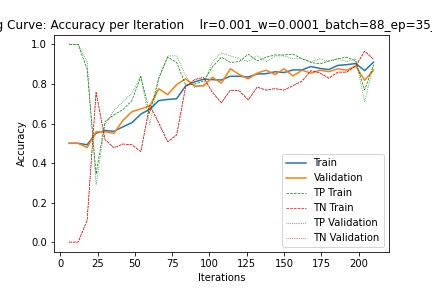



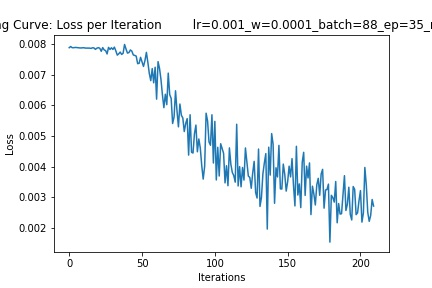

**CNN training curves**


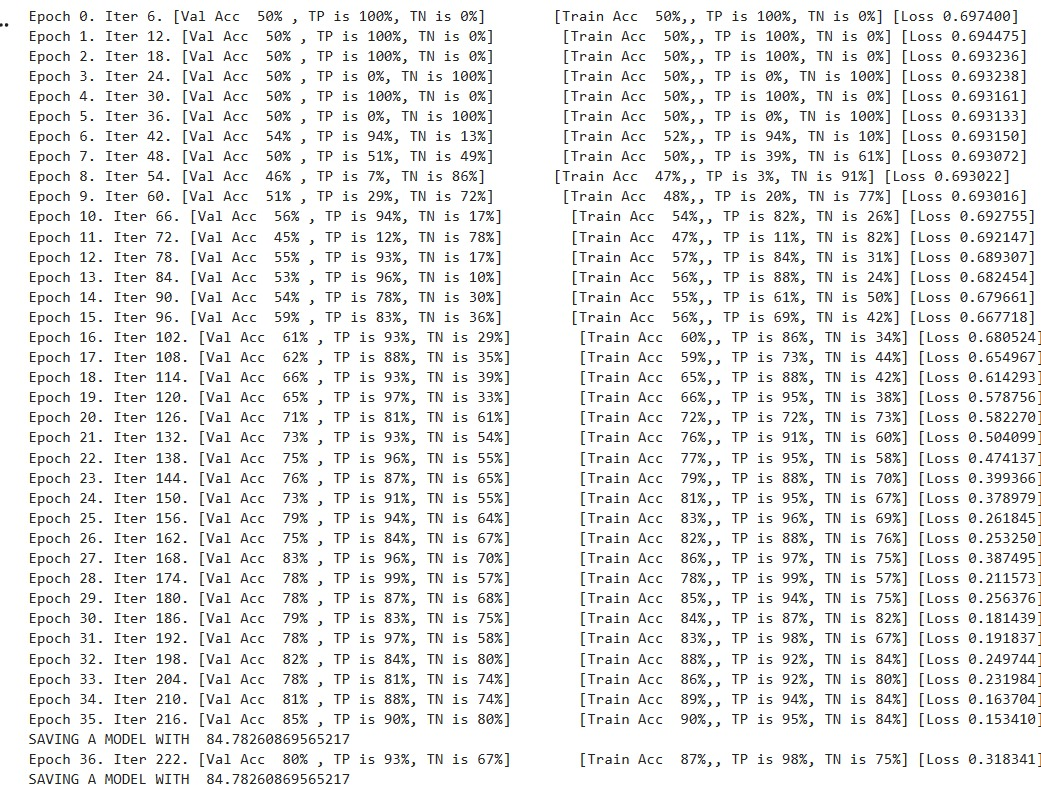



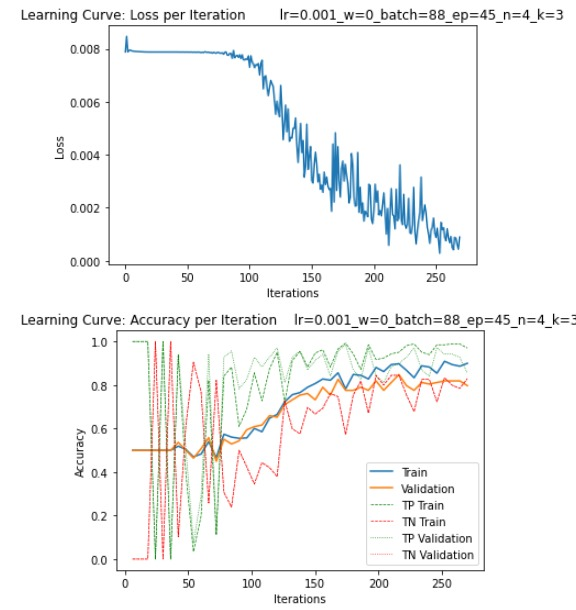

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
# test accuracy for CNNChannel:
TP,TN=get_accuracy(bestCnnChannel,test_m)
print("For man accuracy we got TP= ",TP*100,"% , and  TN is ",TN*100,"%")

TP,TN=get_accuracy(bestCnnChannel,test_w)
print("For woman accuracy we got TP= ",TP*100,"% , and  TN is ",TN*100,"%")

For man accuracy we got TP=  86.66666666666667 % , and  TN is  93.33333333333333 %
For woman accuracy we got TP=  90.0 % , and  TN is  83.33333333333334 %


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

Model Model on the colab-wall, who’s the same pair of them all?  [[ True]]
Model Model on the colab-wall, who’s the same pair of them all?  [[False]]


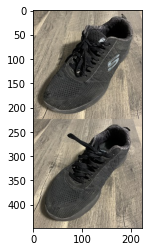

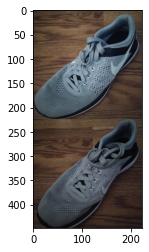

In [ ]:
def predicte_me_plz(model,data):
  xs=torch.Tensor(np.expand_dims(data,0)).transpose(1,3).transpose(2,3)
  zs=model(xs)
  pred=zs.max(1,keepdim=True)[1]
  pred=pred.detach().numpy()
  return pred==0 #if 0 they are the same pair so TRUE, else FALSE for negative pair

same_pair= generate_same_pair(test_m)
#correct pair:
print("Model Model on the colab-wall, who’s the same pair of them all? ",predicte_me_plz(bestCnnChannel,same_pair[1]))
plt.figure()
plt.imshow(same_pair[1]+0.5)

#not correct pair:
print("Model Model on the colab-wall, who’s the same pair of them all? ",predicte_me_plz(bestCnnChannel,same_pair[6]))
plt.figure()
plt.imshow(same_pair[6]+0.5)



### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Model Model on the colab-wall, who’s the same pair of them all?  [[ True]]
Model Model on the colab-wall, who’s the same pair of them all?  [[False]]


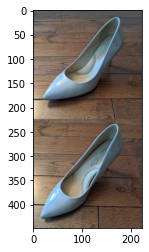

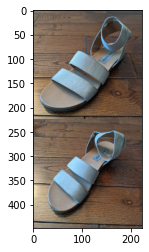

In [ ]:
same_pair= generate_same_pair(test_w)
#correct pair:  
print("Model Model on the colab-wall, who’s the same pair of them all? ",predicte_me_plz(bestCnnChannel,same_pair[0]))
plt.figure()
plt.imshow(same_pair[0]+0.5)

#not correct pair:
print("Model Model on the colab-wall, who’s the same pair of them all? ",predicte_me_plz(bestCnnChannel,same_pair[1]))
plt.figure()
plt.imshow(same_pair[1]+0.5)